In [54]:
# Imports
import pandas as pd
import numpy as np
from rdkit import Chem
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from main import create_dataframe


In [55]:
# Import data
data_raw = pd.read_csv('tested_molecules.csv')


In [56]:
# Make a dataframe with all the molecular descriptors

df_descriptors= create_dataframe(data_raw)

inhibitors1= df_descriptors[(df_descriptors['PKM2_inhibition'] == 1)]
inhibitors2= df_descriptors[(df_descriptors['ERK2_inhibition'] == 1)]
noninhibitors= df_descriptors[(df_descriptors['PKM2_inhibition'] == 0) & (df_descriptors['ERK2_inhibition'] == 0)]
df_descriptors= df_descriptors.drop(columns = ['SMILES','PKM2_inhibition','ERK2_inhibition'])
pd.set_option('display.max_columns', None) # This helps with viewing the dataframes



In [57]:
# Check if there are columns without variation
non_variating_columns = df_descriptors.columns[df_descriptors.nunique()==1].tolist()
print(non_variating_columns) # Use this also to later delete these when testing the test set
# These columns do not add anything, so these get deleted
df_descriptors.drop(columns = non_variating_columns, inplace = True)


['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11', 'fr_HOCCN', 'fr_SH', 'fr_aldehyde', 'fr_azide', 'fr_azo', 'fr_benzodiazepine', 'fr_diazo', 'fr_epoxide', 'fr_hdrzine', 'fr_hdrzone', 'fr_isocyan', 'fr_isothiocyan', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_term_acetylene', 'fr_thiocyan']


In [58]:
# Apply Min-Max scaling
scaler= MinMaxScaler()
df_descriptors_scaled= scaler.fit_transform(df_descriptors)

# Apply PCA
pca = PCA()
components = pca.fit_transform(df_descriptors_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to capture at least 90% variance
num_components = np.argmax(cumulative_variance >= 0.85) + 1

# Print the result
print(f'Number of principal components needed to capture at least 80% variance: {num_components}')
pca.explained_variance_ratio_[0]*100

Number of principal components needed to capture at least 80% variance: 266


3.4647674126264105

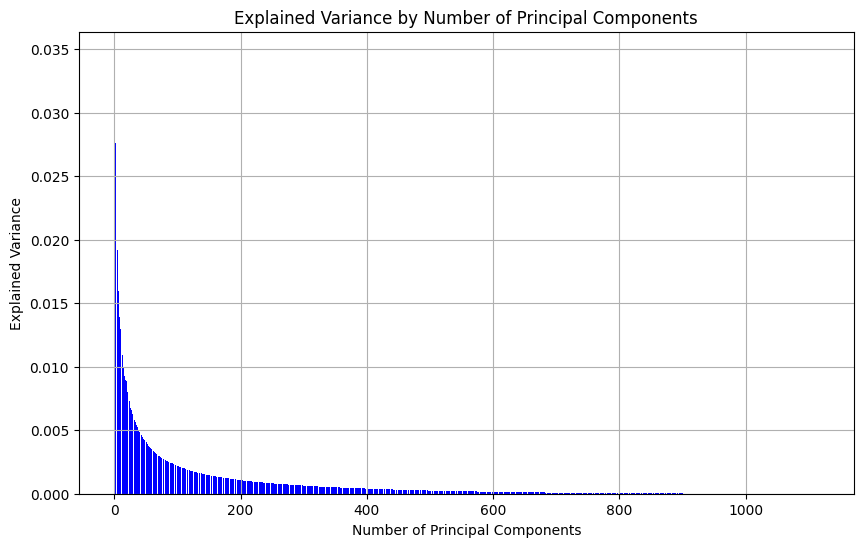

In [59]:
# Make a figure 
plt.figure(figsize=(10, 6))
plt.bar(range(len(pca.explained_variance_ratio_)),
        pca.explained_variance_ratio_, color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

In [75]:
# Perform PCA with 26 components
number_of_components= 3
pca = PCA(n_components=number_of_components)
pca_scores = pca.fit_transform(df_descriptors_scaled)

# Create a DataFrame with PCA scores
pca_df = pd.DataFrame(data=pca_scores, columns=['PC'+ str(number+1) for number in range(number_of_components)])

pca_loadings_df= pd.DataFrame(data= pca.components_.T , columns=['PC'+ str(number +1)+ '_loading' for number in range(number_of_components)])


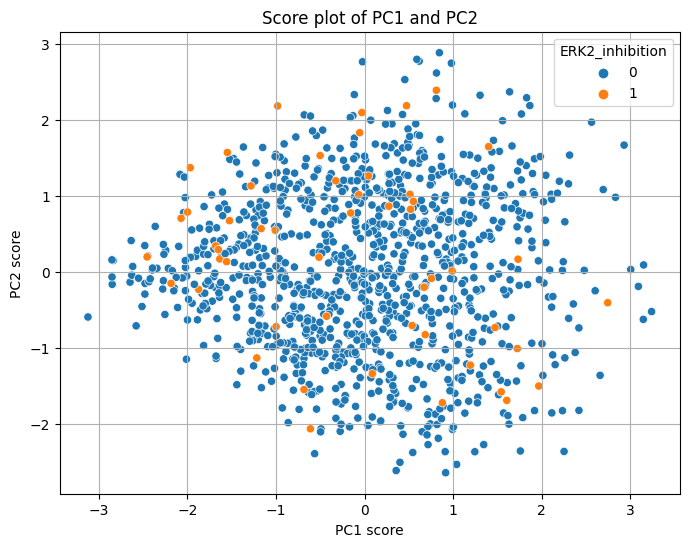

In [76]:
# Plot the PCA scores
pca_df['PKM2_inhibition']= data_raw['PKM2_inhibition']
pca_df['ERK2_inhibition']= data_raw['ERK2_inhibition']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue= 'ERK2_inhibition')
plt.xlabel('PC1 score')
plt.ylabel('PC2 score')
plt.title('Score plot of PC1 and PC2')
plt.grid(True)
plt.show()

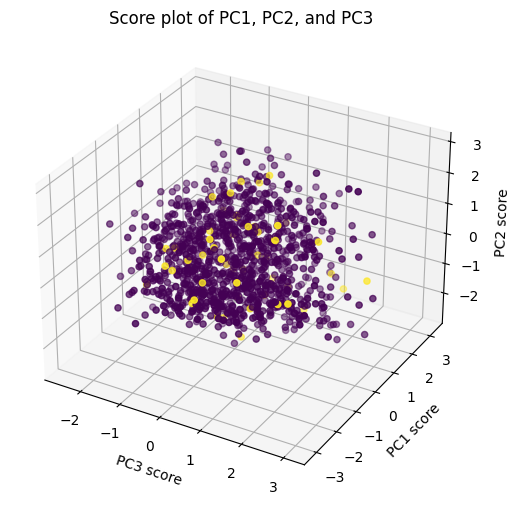

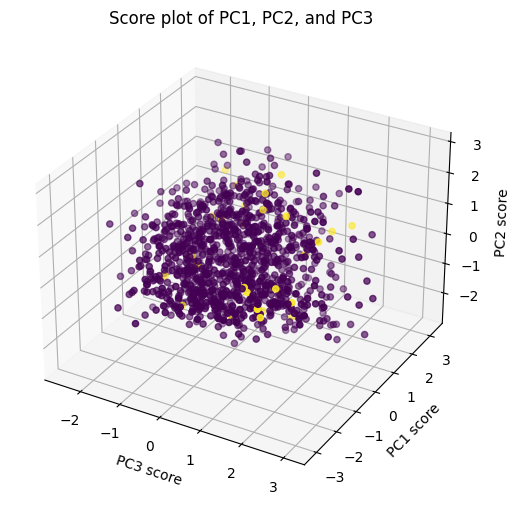

In [77]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_df['PC3'], pca_df['PC1'], pca_df['PC2'], c=pca_df['ERK2_inhibition'], cmap='viridis')

ax.set_xlabel('PC3 score')
ax.set_ylabel('PC1 score')
ax.set_zlabel('PC2 score')
ax.set_title('Score plot of PC1, PC2, and PC3')
ax.grid(True)

plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_df['PC3'], pca_df['PC1'], pca_df['PC2'], c=pca_df['PKM2_inhibition'], cmap='viridis')

ax.set_xlabel('PC3 score')
ax.set_ylabel('PC1 score')
ax.set_zlabel('PC2 score')
ax.set_title('Score plot of PC1, PC2, and PC3')
ax.grid(True)

plt.show()

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

for i in range(100):
    # Veronderstel dat de laatste kolom de label kolom is
    X = pca_df  # Features
    y = data_raw['PKM2_inhibition']   # Labels

    # Splitsen van de data in trainings- en testsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # # Normaliseren van de features
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    # SVM model trainen
    svm = SVC(kernel='poly')  # Je kunt ook andere kernels proberen zoals 'rbf', 'poly', enz.
    svm.fit(X_train, y_train)

    # Voorspellingen maken
    y_pred = svm.predict(X_test)
    # Evaluatie van het model
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

[[217   0]
 [  2   5]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       217
           1       1.00      0.71      0.83         7

    accuracy                           0.99       224
   macro avg       1.00      0.86      0.91       224
weighted avg       0.99      0.99      0.99       224

[[218   0]
 [  2   4]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       218
           1       1.00      0.67      0.80         6

    accuracy                           0.99       224
   macro avg       1.00      0.83      0.90       224
weighted avg       0.99      0.99      0.99       224

[[218   0]
 [  1   5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      0.83      0.91         6

    accuracy                           1.00       224
   macro avg       1.00      0.92      0.95       224
weigh